详细见：https://www.zybuluo.com/hanbingtao/note/485480
=====
  
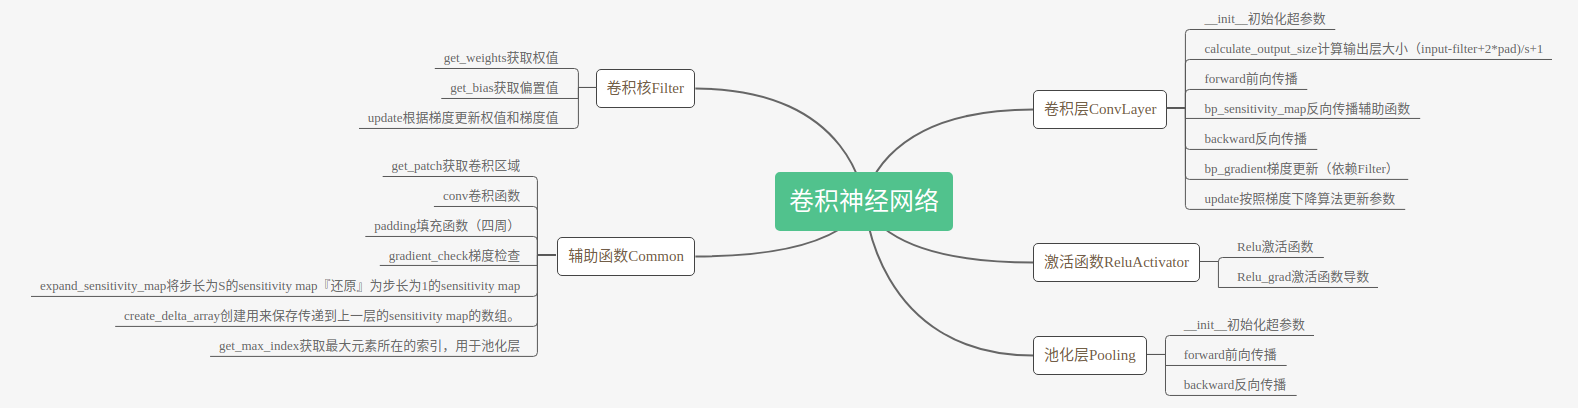

In [11]:
import numpy as np

一：实现卷积核Filter
=============

In [19]:
class Filter(object): #其实卷积核就是我们的权值，所谓权值共享就是体现在这里，各个局部视野下使用同一个卷积核（权值矩阵）
    def __init__(self,width,hight,depth):
        self.weights = np.random.uniform(-1e-4,1e-4,(depth,hight,width))
        self.bias = 0
        self.weights_grad = np.zeros(self.weights.shape)
        self.bias_grad = 0
        
    def get_weights(self):
        return self.weights
    
    def get_bias(self):
        return self.bias
    
    def update(self,learning_rate): #更新权值信息
        self.weights -= learning_rate*self.weights_grad
        self.bias -= learning_rate*self.bias_grad

二：实现激活函数ReluActivator
========

In [106]:
class ReluActivator(object):
    def relu_func(self,input_): #激活函数
        return max(0,input_)

    def relu_grad(self,output): #导函数
        return 1 if output > 0 else 0
    
class IdentityActivator(object): #f(x) = x 后面梯度检验的时候使用了
    def relu_func(self,input_):
        return input_
    
    def relu_grad(self,output):
        return 1

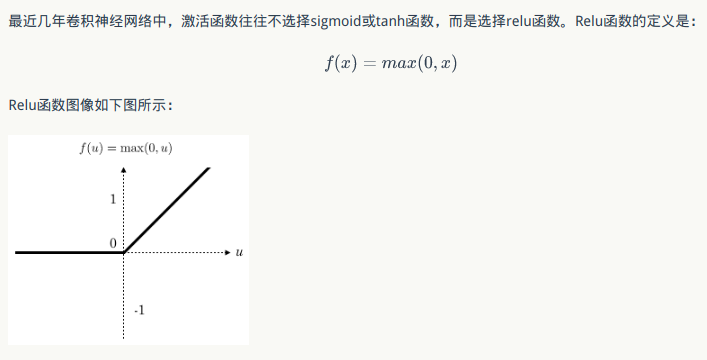

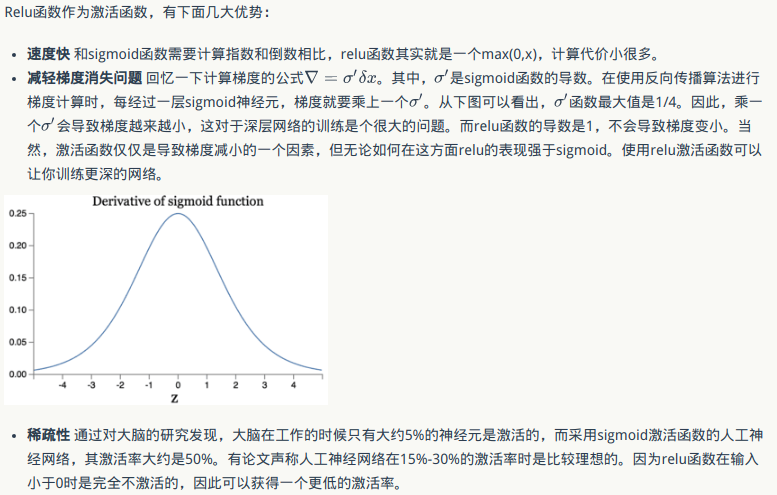

三：实现卷积层ConvLayer
=============

1:前向传播计算
------
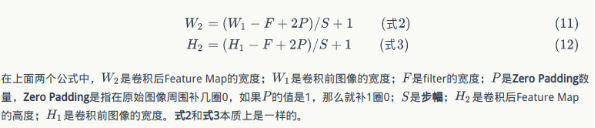

步长为1：
  
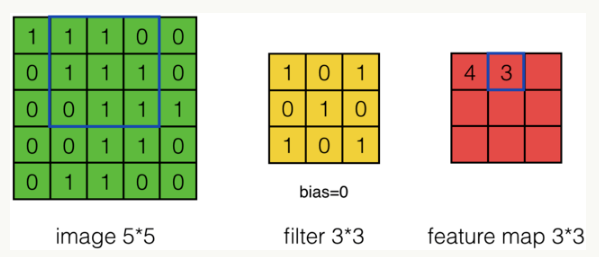
  
步长为2：
  
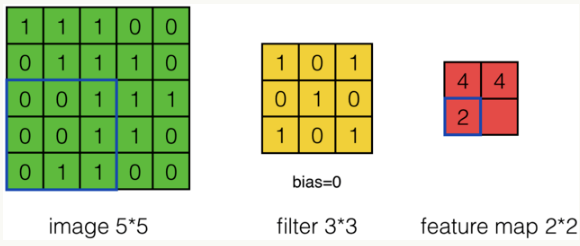
  
步长为1与步长为2的差别：
  
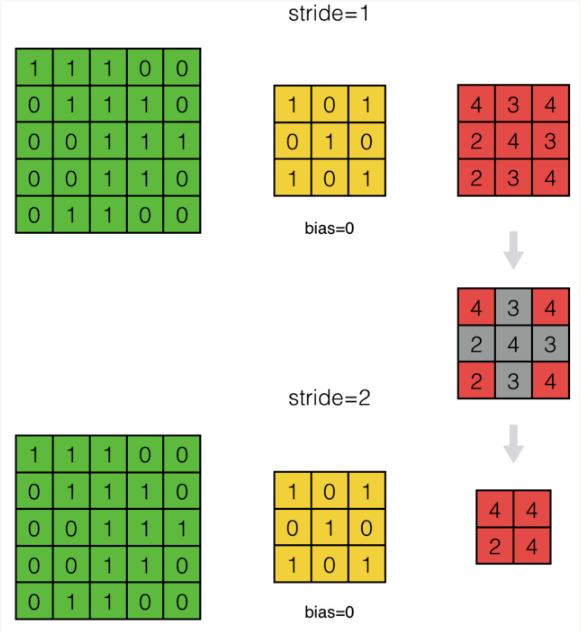
  
如上图，上面是步长为1时的卷积结果，下面是步长为2时的卷积结果。我们可以看出，因为步长为2，得到的feature map跳过了步长为1时相应的部分。
  
重点补充：因此，当我们反向计算误差项时，我们可以对步长为S的sensitivity map相应的位置进行补0，将其『还原』成步长为1时的sensitivity map，再用反向传播中式8进行求解。

2：反向传播
-------
1.案例推导：假设输入的大小为3*3，filter大小为2*2，按步长为1卷积，我们将得到2*2的feature map。如下图所示
  
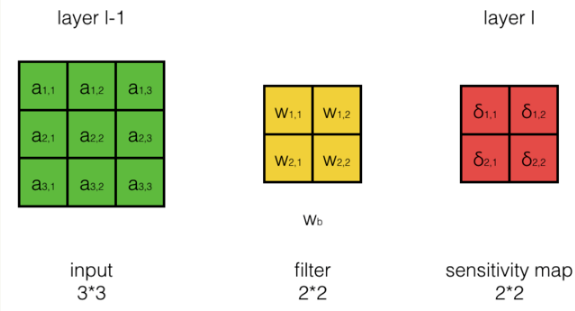

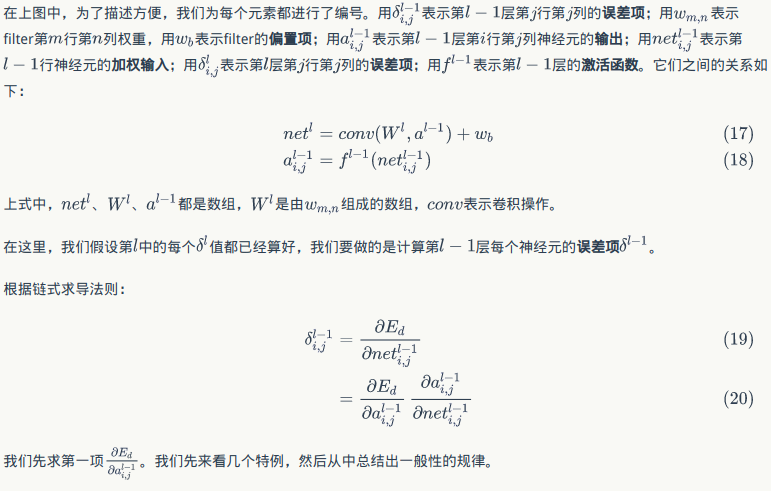

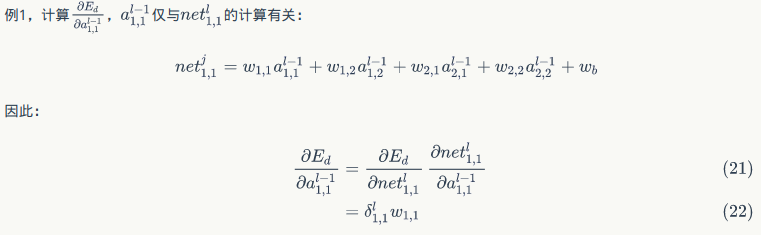

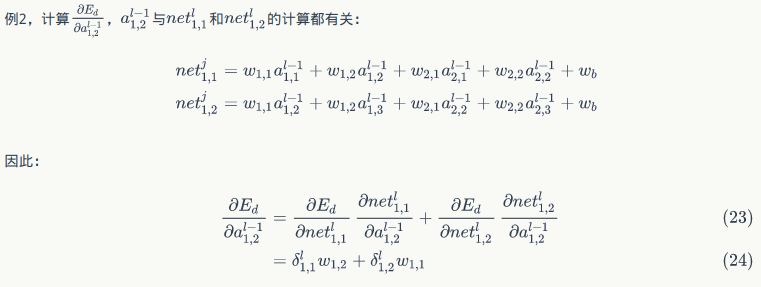

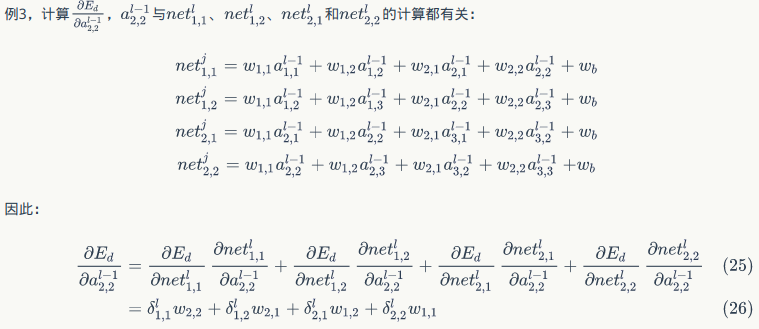
  
从上面3个例子中，我们不难发现：在步长为1时，计算：
  
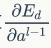
  
相当于，把第l层的sensitive map周围补一圈0，在与180度翻转后（注意：是翻转，不是旋转）的filter进行cross-correlation，就能得到想要结果，如下图所示：
  
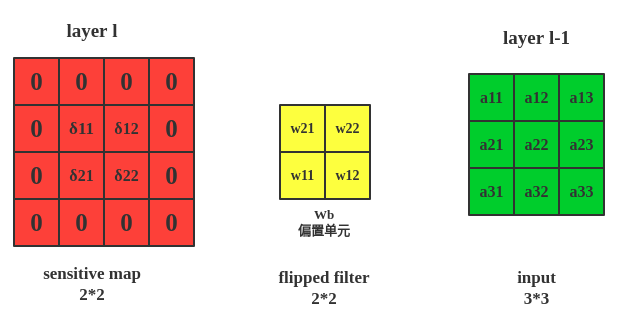
  
当然，对于步长不为1时，我们也有相关的公式，判断填充数量：因为在进行反响传播过程中，也是一次卷积过程，所以我们按照卷积可以推导出：
  
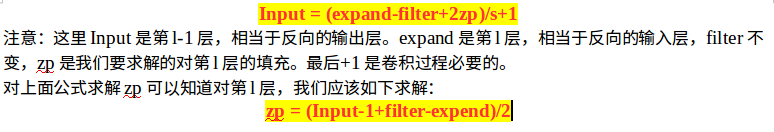
  
下面接着讨论反向传播步长为1的情况：
因为卷积相当于将filter旋转180度的cross-correlation，因此上图的计算可以用卷积公式（注意：下面公式还是卷积）完美的表达：
  
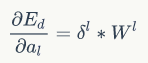

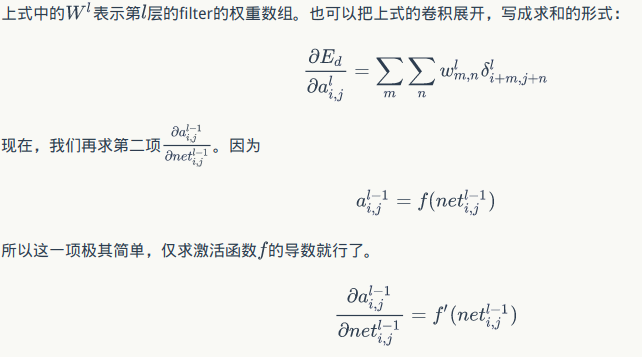

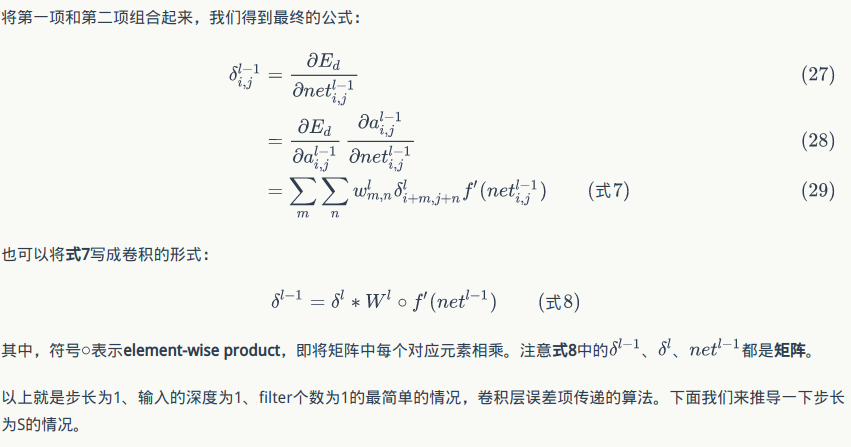

以上：我们获取的求解δ的最终表达式（公式8）

3：反向传播输入层深度为D时的误差传递
-------
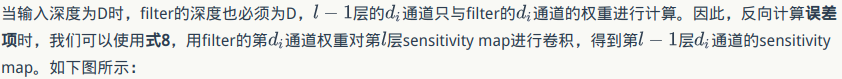

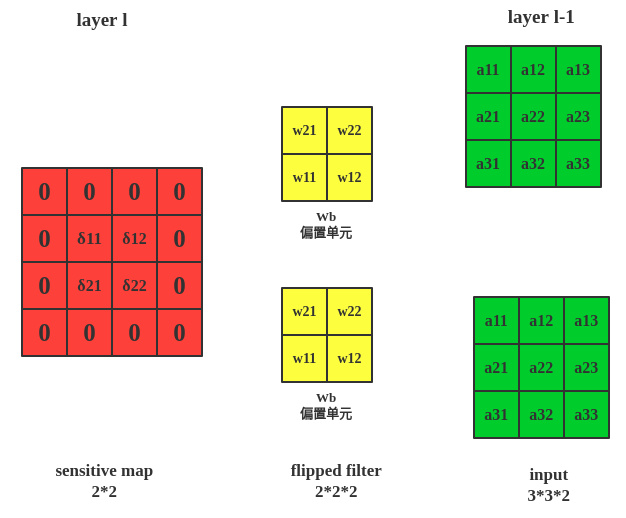
  
filter数量为N时的误差传递:
  
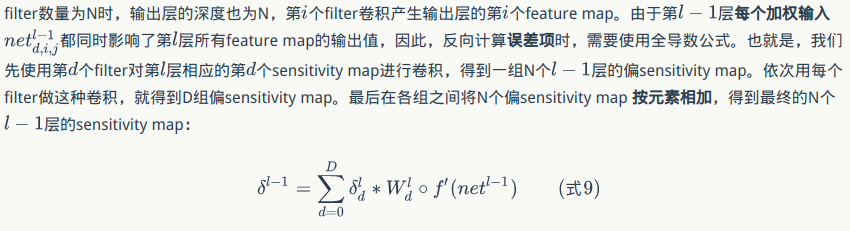
  
以上就是卷积层误差项传递的算法。详细参考代码

4：卷积层filter权重梯度的计算
-------
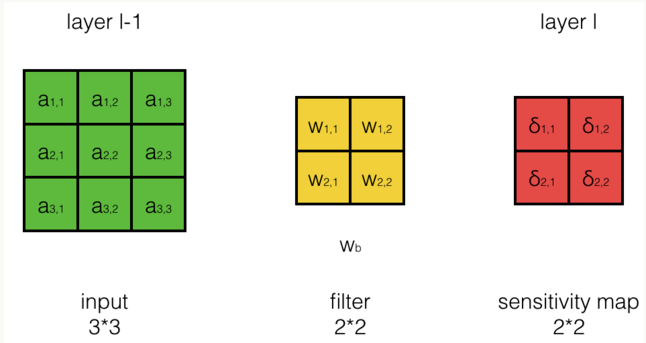

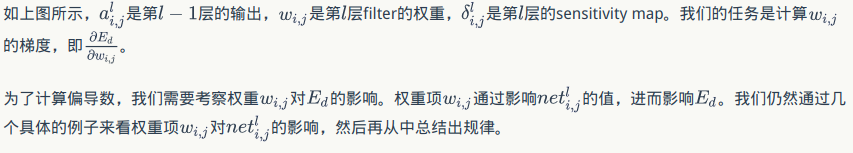

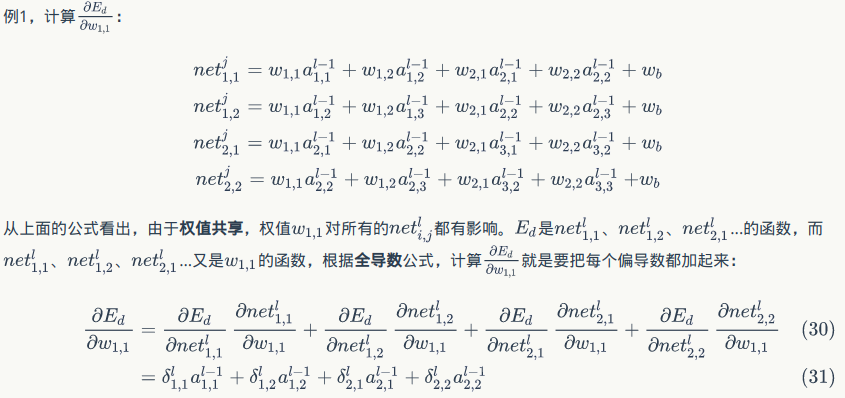

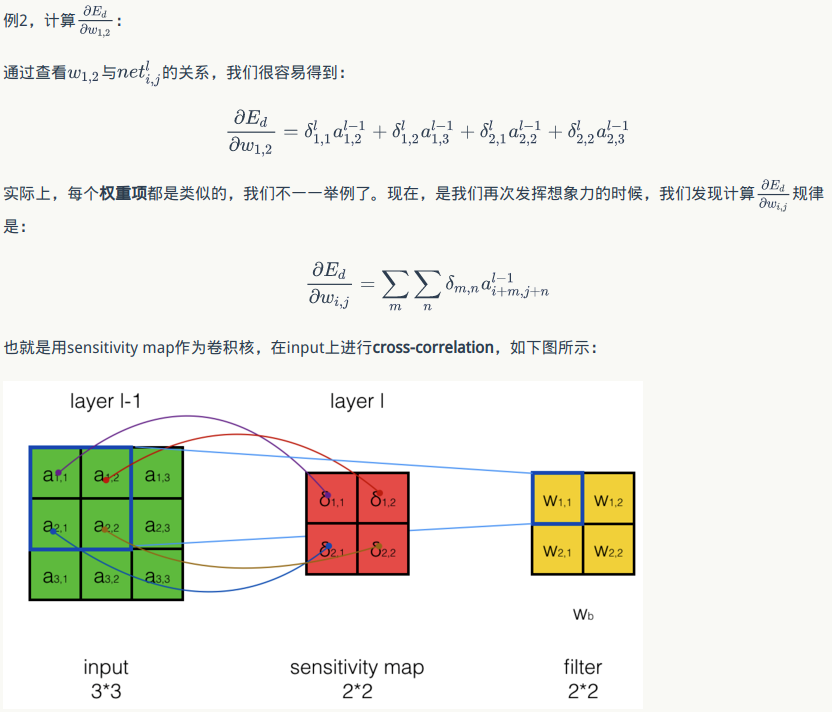

注意：这里同样需要对输出层进行扩展为步长为1的情况，然后统一处理
  
上面还是一次卷积操作，只不过又调整了一次输入、输出、卷积核位置。所以卷积操作还是特别重要的！！！！
  
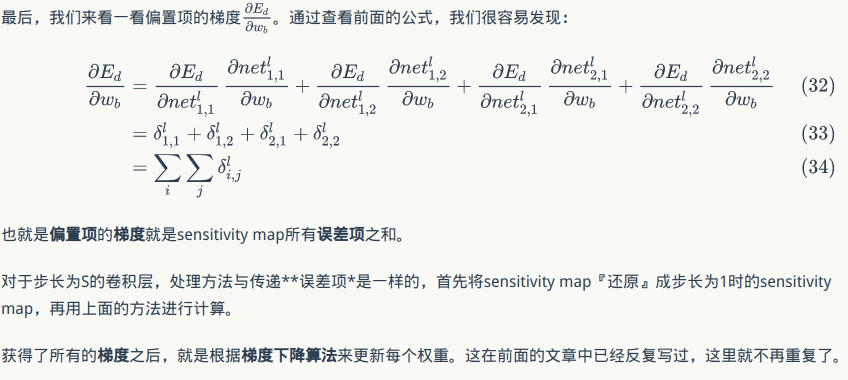

In [131]:
class ConvLayer(object):
    def __init__(self,input_width,input_hight,channel_number,
                filter_width,filter_hight,filter_number,
                padding_number,stride_number,activator_func,learning_rate):
        #输入层数据
        self.input_width = input_width
        self.input_hight = input_hight
        self.channel_number = channel_number
        
        self.input_array = None #输入数据
        self.padded_input_array = None #输入数据填充结果
        
        #根据卷积核信息，构造卷积核类对象
        self.filter_width = filter_width
        self.filter_hight = filter_width
        self.filter_number = filter_number
        
        self.filters = []
        for i in range(filter_number): #每个filter的信息都是与前一层有关（输入层），所有filter的数量与输出层有关
            self.filters.append(Filter(filter_width,filter_hight,channel_number)) #实例化卷积核，加入卷积层中
            
        #根据填充、步长等信息，获取输出层信息----注意：我们这里输入层的数据并没有给出，是后面前向传播计算出来的，所以后面尽可能不要直接使用output_array
        self.output_width = ConvLayer.calculate_output_size(input_width,filter_width,padding_number,stride_number)
        self.output_hight = ConvLayer.calculate_output_size(input_hight,filter_hight,padding_number,stride_number)

        self.output_array = np.zeros((self.filter_number,self.output_hight,self.output_width))
        
        #其他信息
        self.padding_number = padding_number #输入层是否需要填充 same
        self.stride_number = stride_number #卷积过程步长
        self.activator_func = activator_func #激活单元需要激活函数
        self.learning_rate = learning_rate #学习速率
    
    @staticmethod #在init函数调用，设置为classmethod或者staticmethod----也可以设置到辅助函数中去
    def calculate_output_size(input_size,filter_size,padding_number,stride_number):
        return int((input_size-filter_size+padding_number*2)/stride_number+1)
    
    def forward(self,input_array): #前向传播
        self.input_array = input_array
        self.padded_input_array = padding(input_array,self.padding_number) #填充函数见四
        #print(self.padded_input_array)
        #开始前向传播卷积操作 卷积函数见四
        for f in range(self.filter_number):
            filter_ = self.filters[f]
            conv(self.padded_input_array,filter_.get_weights(),self.output_array[f],self.stride_number,filter_.get_bias())

        #print(self.output_array) #这里是我们下面test()测试前向传播的正确结果（没有进行relu激活项求解）
        #卷积后计算元素激活项值---element_wise_op是对多维数据进行单个数据的修改，见四
        element_wise_op(self.output_array,self.activator_func.relu_func)
        
    #获取前一层l-1层的delta值,不同于前向传播的卷积方式（前向传播直接使用3维运算，反向传播需要单独对2维处理）---不同就是看每次的输入层和卷积核的深度是否保持一致，一致则直接3维卷积，不一致则拆成2维单独处理
    #另外：第i个卷积核是与输出层的第i个深度有关的！！！
    def bp_sensitivity_map(self,sensitivity_array,activator): #反向传播辅助函数 sensitivity_array就是相当于输入的output_array
        #按上面的方法，对原始sensitivity_array进行扩展
        expand_array = expand_sensitivity_map(sensitivity_array,self.input_hight,self.input_width,self.filter_hight,self.filter_width,self.padding_number,self.stride_number)
        expand_width = expand_array.shape[2]
        #上面获取了步长为1时的输出矩阵，我们开始根据上面求解zp的方法，对扩展后的sensitive map进行填充四周
        zp = int((self.input_width+self.filter_width-1-expand_width)/2)
        padded_array = padding(expand_array,zp)  #获取了反向传播过程中的最终输入（一会作为输入进行卷积）
        #print("==================")
        #print(padded_array)
        #print("==================")
        #参考上面标题3
        #初始化上一层的δ值----对于具有多个filter的卷积层来说，最终传递到上一层的sensitivity map相当于所有的filter的sensitivity map之和
        self.delta_array = create_delta_array(self.channel_number,self.input_hight,self.input_width)
        
        #参考标题3,进行反向误差计算
        for f in range(self.filter_number): #------卷积核数
            filter_ = self.filters[f]
            #将filter权重翻转180度
            flipped_weights = np.rot90(filter_.get_weights(),2)[::-1] #可以实现翻转
            #print("}666666666666666666666666666{")
            #print(filter_.get_weights())
            #print(f,flipped_weights)
            #计算每一次与filter_卷积后的delta_array,累加到后面全局delta中去
            delta_array_ = create_delta_array(self.channel_number,self.input_hight,self.input_width)
            #开始卷积操作
            for d in range(delta_array_.shape[0]): #-------同卷积核深度
                #print(d)
                #print(padded_array[f])
                #print(flipped_weights[d])
                conv(padded_array[f],flipped_weights[d],delta_array_[d],1,0) #conv是适配于二、三维度的，上面前向传播直接3维即可，这里反向传播维度不匹配，需要对2维处理
                #print(delta_array_[d])
                #padded_array由前向传播知道，与卷积核数量有关，所以用f;flipped_weights与输入层（同卷积核深度有关）用d,delta_array_同理是对l-1输入层处理，用d            
            self.delta_array += delta_array_#先累加，后面统一乘导数，求解delta
            #print(self.delta_array)
            #print("}999999999999999999999999999{")
            
        
        #求解delta需要与输入层导数相乘
        deravative_array = np.array(self.input_array)
        element_wise_op(deravative_array,activator.relu_grad)
        
        self.delta_array *= deravative_array
    
    #输出层的第i个深度，与第i个卷积核有关
    #更新卷积核的梯度：见标题4---求梯度与每层的delta有关，而每层的delta由bp_sensitivity_map求解（但是其是求l-1层delta,但是用的是原始的权值）
    def bp_gradient(self,sensitivity_array):
        #print("----------------gradient--------------------")
        #处理卷积步长，扩展sensitivity_array
        expand_array = expand_sensitivity_map(sensitivity_array,self.input_hight,self.input_width,self.filter_hight,self.filter_width,self.padding_number,self.stride_number)
        #print(expand_array)
        #开始进行卷积处理
        for f in range(self.filter_number): #卷积核个数
            filter_ = self.filters[f] #sensitivate map深度与卷集合数量相同
            for d in range(filter_.get_weights().shape[0]): #卷积核深度与input_array同深度
                conv(self.padded_input_array[d],expand_array[f],filter_.weights_grad[d],1,0)
            #print(filter_.weights_grad)
            #更新当前卷积核的偏置项梯度
            filter_.bias_grad = expand_array[f].sum()
            #print(filter_.bias_grad)
    
    def backward(self,input_array,sensitivity_array,activator): #反响传播
        #先前向传播，记录输出值
        self.forward(input_array)
        #使用反向传播辅助函数，求解前一层的delta
        self.bp_sensitivity_map(sensitivity_array,activator)
        #更新每个filter卷积核的梯度值
        self.bp_gradient(sensitivity_array)
        
    def update(self): #更新卷积核的权值
        for filter_ in self.filters:
            filter_.update(self.learning_rate)
        

四：辅助函数（其实全部放入ConvLayer中也可以，但是该类太过臃肿）
======

In [132]:
#一：输入数据填充函数
def padding(input_array,padding_number):
    if padding_number == 0:
        return input_array
    if input_array.ndim == 3: #3维图像
        pad_array = np.zeros((input_array.shape[0],input_array.shape[1]+2*padding_number,input_array.shape[2]+2*padding_number))
        pad_array[:,padding_number:(input_array.shape[1]+padding_number),padding_number:(input_array.shape[2]+padding_number)] = input_array
        return pad_array
    elif input_array.ndim == 2:
        pad_array = np.zeros((input_array.shape[0]+2*padding_number,input_array.shape[1]+2*padding_number))
        pad_array[padding_number:(input_array.shape[0]+padding_number),padding_number:(input_array.shape[1]+padding_number)] = input_array
        return pad_array

In [133]:
#二：获取输入数据本次用于卷积的区域,i,j为索引次数,都是从0开始---为卷积函数conv做准备
def get_patch(input_array,i,j,filter_height,filter_width,stride):
    start_i = i*stride;
    start_j = j*stride
    if input_array.ndim == 2:
        return input_array[start_i:start_i+filter_height,start_j:start_j+filter_width]
    elif input_array.ndim == 3:
        return input_array[:,start_i:start_i+filter_height,start_j:start_j+filter_width]

In [134]:
#三：卷积函数，一次处理一个filter_array,虽然存在多个filter_array，但是是由调用函数进行处理的
def conv(input_array,filter_array,output_array,stride,bias): #input_array,filter_array是相同深度的3D或者2D数据，output_array是深度为1的2D数据
    #我们根据output_array，就可以知道要迭代多少次
    output_hight = output_array.shape[0]
    output_width = output_array.shape[1]
    
    filter_hight = filter_array.shape[0]
    filter_width = filter_array.shape[1]
    
    for i in range(output_hight):
        for j in range(output_width): #注意：下面*是矩阵中对应元素相乘
            output_array[i][j] = (get_patch(input_array,i,j,filter_hight,filter_width,stride)*filter_array).sum()+bias

In [135]:
#四：我们的激活函数是针对单个值，而我们的数据是多维，所以我们需要一个函数进行数据转换处理
def element_wise_op(array,op):
    for i in np.nditer(array,op_flags=["readwrite"]): #数据单个迭代,无论几维，都处理为单个数据处理
        i[...] = op(i)  #[...]表示对原始数据进行修改

In [136]:
#五：扩展函数，和填充类似，但是是在中间进行填充（详解见下面的说明）---sensitivity是3维的（filter_number,卷积后高度，卷积后宽度）
def expand_sensitivity_map(sensitivity_array,input_height,input_width,filter_height,filter_width,padding_number,stride_number=1): #需要提供后面的参数，来计算步长为1时的矩阵形状
    depth = sensitivity_array.shape[0]
    #根据参数，计算扩展后的sensitivity_array大小、
    expanded_height = int((input_height-filter_height+2*padding_number)/1 + 1) #步长为1（可以省略，这里为了详细说明加上）    
    expanded_width = int((input_width-filter_width+2*padding_number)/1 + 1) #步长为1（可以省略，这里为了详细说明加上）
    
    #构建新的sensitivity_map
    expand_array = np.zeros((depth,expanded_height,expanded_width))
    
    #从原始数据中，进行填充数据到新的扩展后的expanded_array中去
    for i in range(sensitivity_array.shape[1]):
        for j in range(sensitivity_array.shape[2]):
            i_pos = i * stride_number
            j_pos = j * stride_number
            expand_array[:,i_pos,j_pos] = sensitivity_array[:,i,j] #从原始数据提取到新的扩展数据中去
    
    return expand_array


前向传播：（步长1到步长2,缩小了输出大小）
---
  
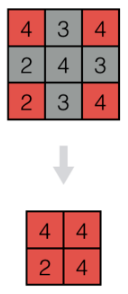


反向传播：（进行逆向扩展，将所有步长统一扩展为步长为1的情况）
---
  
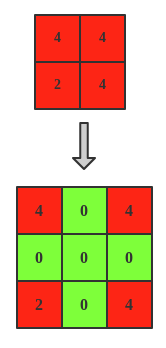
  
我们需要先进行填充，变为步长为1的矩阵，然后对该矩阵进行填充（填充不在这里实现，具体求解zp方法方式上面已经提及），变为步长为1的方法如下：
  
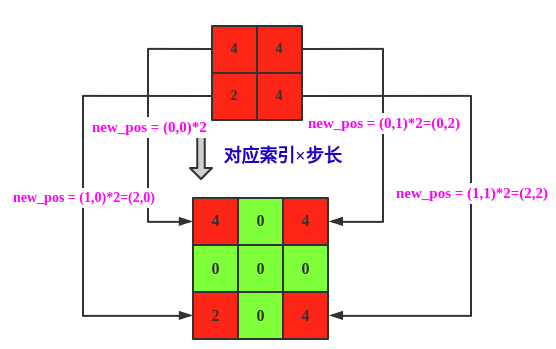

In [137]:
#六：根据上面小标题3,获取l-1层的δ
def create_delta_array(channel_number,input_height,input_width): #第l-1层实际就是利用l层对输入层l-1处理，求解l-1层的δ
    return np.zeros((channel_number,input_height,input_width))

In [186]:
#七：获取一个矩阵中最大元素所在的索引（池化层要用）
def get_max_index(input_array):
    m,n = input_array.shape
    max_i,max_j = 0,0
    max_val = input_array[0][0]
    
    for i in range(m):
        for j in range(n):
            if(input_array[i][j]>max_val):
                max_i,max_j = i,j
    
    return max_i,max_j

五：开始测试上面卷积的实现
=======

In [181]:
def init_test():
    a = np.array(
        [[[0,1,1,0,2],
          [2,2,2,2,1],
          [1,0,0,2,0],
          [0,1,1,0,0],
          [1,2,0,0,2]],
         [[1,0,2,2,0],
          [0,0,0,2,0],
          [1,2,1,2,1],
          [1,0,0,0,0],
          [1,2,1,1,1]],
         [[2,1,2,0,0],
          [1,0,0,1,0],
          [0,2,1,0,1],
          [0,1,2,2,2],
          [2,1,0,0,1]]])
    b = np.array(
        [[[0,1,1],
          [2,2,2],
          [1,0,0]],
         [[1,0,2],
          [0,0,0],
          [1,2,1]]])
    cl = ConvLayer(5,5,3,3,3,2,1,2,IdentityActivator(),0.001)
    cl.filters[0].weights = np.array(
        [[[-1,1,0],
          [0,1,0],
          [0,1,1]],
         [[-1,-1,0],
          [0,0,0],
          [0,-1,0]],
         [[0,0,-1],
          [0,1,0],
          [1,-1,-1]]], dtype=np.float64)
    cl.filters[0].bias=1
    cl.filters[1].weights = np.array(
        [[[1,1,-1],
          [-1,-1,1],
          [0,-1,1]],
         [[0,1,0],
         [-1,0,-1],
          [-1,1,0]],
         [[-1,0,0],
          [-1,0,1],
          [-1,0,0]]], dtype=np.float64)
    cl.filters[1].bias = 0
    return a, b, cl #获取输入层、输出sensitivaty map、卷积层


def test(): #测试前向传播
    a, b, cl = init_test()
    cl.forward(a)
    print(cl.output_array)

def test_bp(): #测试反向传播
    a, b, cl = init_test() #这里b与前向传播无关，我们使用一个简单的sensitivaty map方便推导结果
    cl.backward(a, b, ReluActivator())
    cl.update()
#     print("------------update----------------")
#     print(cl.filters[0])
#     print(cl.filters[0].get_weights())
#     print(cl.filters[0].get_bias())
#     print(cl.filters[0].weights_grad)
#     print(cl.filters[0].bias_grad)
#     print("==========================")
#     print(cl.filters[1])
#     print(cl.filters[1].get_weights())
#     print(cl.filters[1].get_bias())  
#     print(cl.filters[1].weights_grad)
#     print(cl.filters[1].bias_grad)

In [182]:
test() #测试前向传播

[[[ 6.  7.  5.]
  [ 3. -1. -1.]
  [ 2. -1.  4.]]

 [[ 2. -5. -8.]
  [ 1. -4. -4.]
  [ 0. -5. -5.]]]


结果演示：这里输出的是没有经过激活函数处理的第l层输入值，上面test输出的是经过relu处理的
-----

![Alt Text](https://upload-images.jianshu.io/upload_images/2256672-958f31b01695b085.gif) 

In [183]:
test_bp() #测试反向传播,可以打开bp_sensitivity_map中的注释，推导更容易

In [184]:
#梯度检测
def gradient_check():
    # 设计一个误差函数，取所有节点输出项之和
    error_func = lambda x:x.sum()
    
    #前向传播，获取输出值
    a,b,cl = init_test()
    cl.forward(a)
    
    #j获取sensitivity map----注意：sensitivity map不等于output_array,两者有区别，sensitivity map是反向的delta,不是输出
    sensitivity_array = np.ones(cl.output_array.shape,dtype=np.float64) #全1,与IdentityActivator有关，其求导全为1
    
    #计算梯度
    cl.backward(a,sensitivity_array,IdentityActivator()) #注意：我们这里使用了IdentityActivator，那么前面的init初始化卷积层，也要统一
    
    
    #检查梯度
    epsilon = 1e-4
    
    for d in range(cl.filters[0].weights_grad.shape[0]):
        for i in range(cl.filters[0].weights_grad.shape[1]):
            for j in range(cl.filters[0].weights_grad.shape[2]):
                cl.filters[0].weights[d,i,j] += epsilon #开始一般求导方式
                cl.forward(a)
                err1 = error_func(cl.output_array)
                
                cl.filters[0].weights[d,i,j] -= 2*epsilon
                cl.forward(a)
                err2 = error_func(cl.output_array)
                
                #利用输出值，求解梯度
                expect_grad = (err1-err2)/(2*epsilon)
                cl.filters[0].weights[d,i,j] += epsilon #还原回去

                print("weight for filter0 (%d,%d,%d)------expect_grad:%f------backward:%f------expect_grad-backward=%f"%
                     (d,i,j,expect_grad,cl.filters[0].weights_grad[d,i,j],expect_grad-cl.filters[0].weights_grad[d,i,j]))

In [185]:
gradient_check()

weight for filter0 (0,0,0)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0.000000
weight for filter0 (0,0,1)------expect_grad:6.000000------backward:6.000000------expect_grad-backward=-0.000000
weight for filter0 (0,0,2)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0.000000
weight for filter0 (0,1,0)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0.000000
weight for filter0 (0,1,1)------expect_grad:7.000000------backward:7.000000------expect_grad-backward=-0.000000
weight for filter0 (0,1,2)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0.000000
weight for filter0 (0,2,0)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0.000000
weight for filter0 (0,2,1)------expect_grad:6.000000------backward:6.000000------expect_grad-backward=-0.000000
weight for filter0 (0,2,2)------expect_grad:5.000000------backward:5.000000------expect_grad-backward=-0

疑问：开始不是用Relu函数吗？为啥现在使用了f(x)=x这个线性函数？如果我打算使用Relu函数运用在前向传播中，进行梯度检验，那么sensitivity_array应该如何设置啊？就这一块没明白
-----------

六：池化层
========
无论max pooling还是mean pooling，都没有需要学习的参数。因此，在卷积神经网络的训练中，Pooling层需要做的仅仅是将误差项传递到上一层，而没有梯度的计算。
 
1.Max Pooling误差项的传递
---------
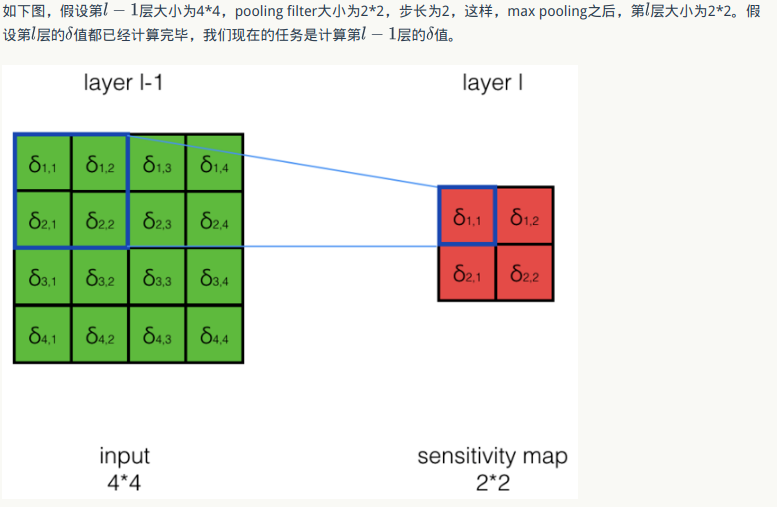

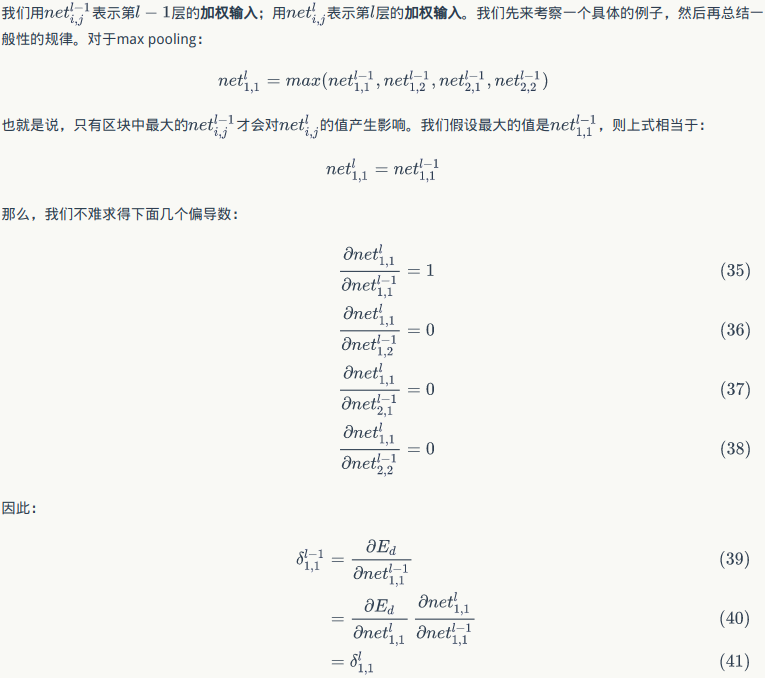

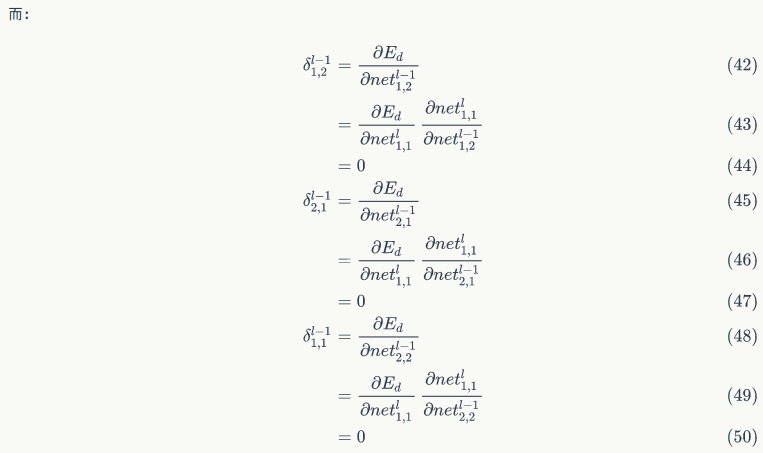

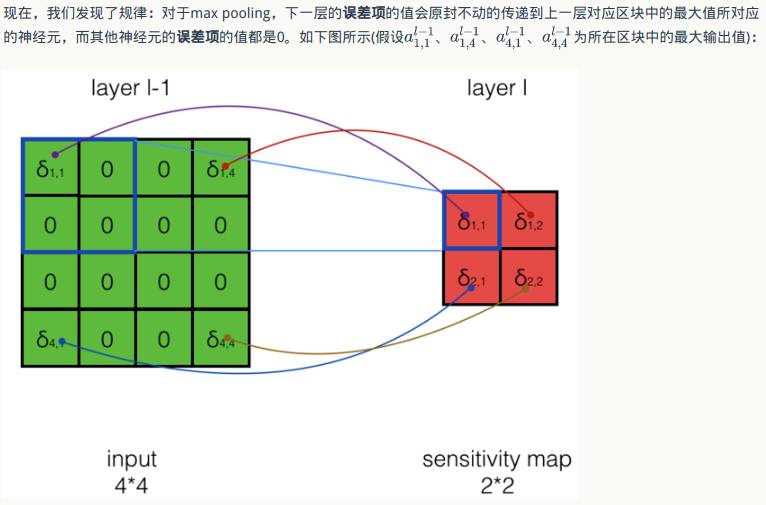

2.Mean Pooling误差项的传递
---------
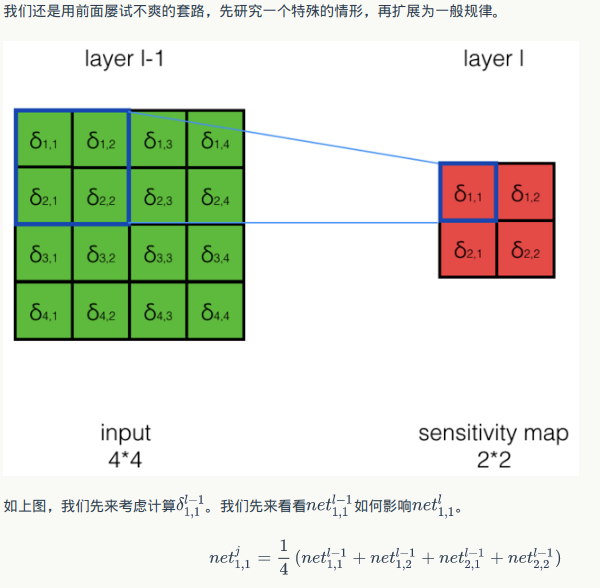

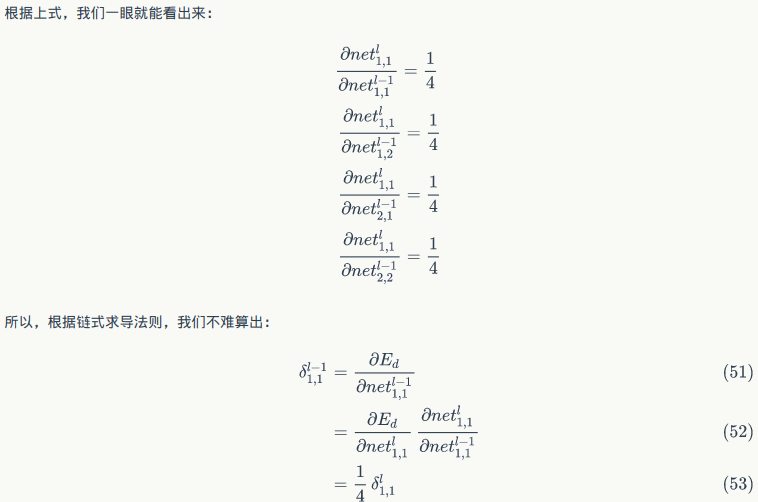

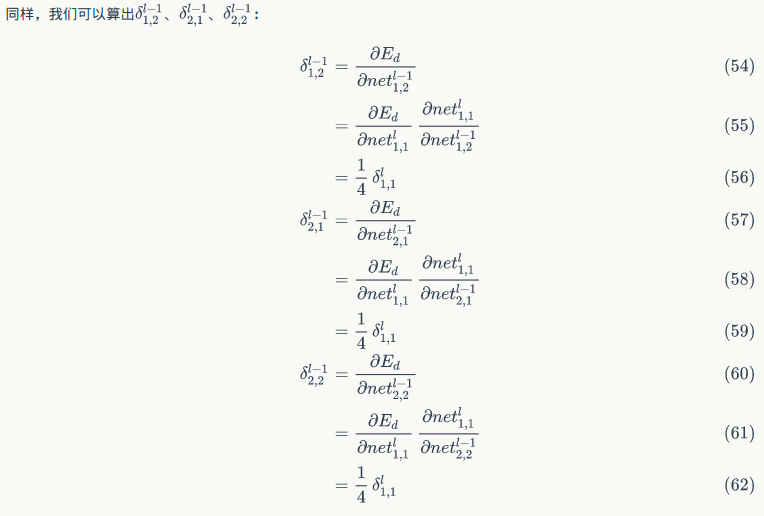

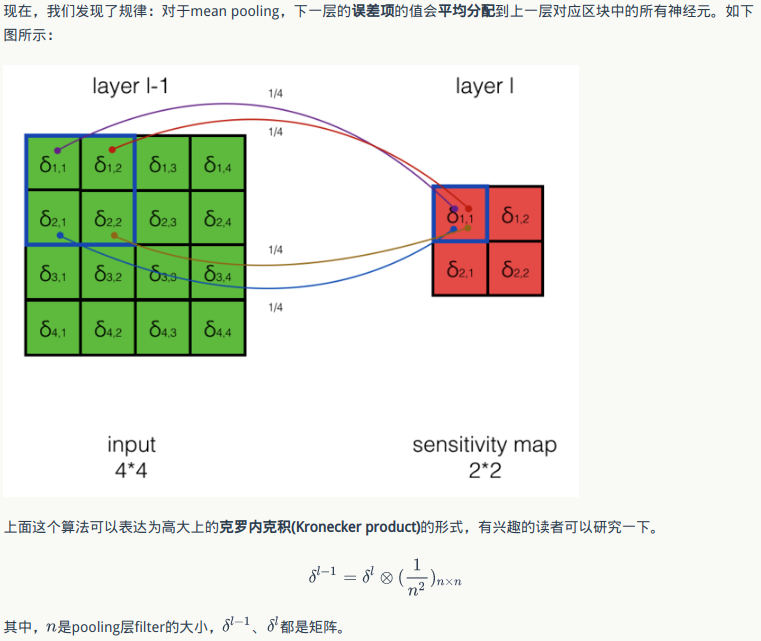

3.三维下的池化问题
--------
http://www.ai-start.com/dl2017/html/lesson4-week1.html#header-n399
  
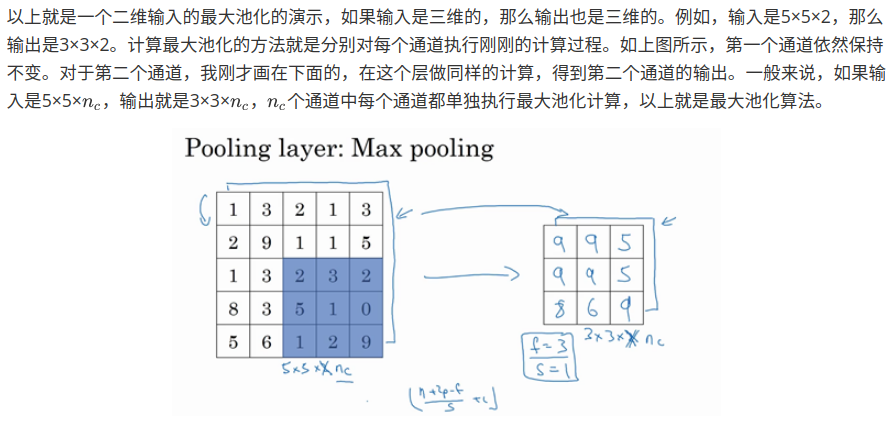

In [200]:
class MaxPoolingLayer(object):
    def __init__(self,input_height,input_width,channel_number,filter_height,filter_width,stride):
        #这里获取filter_xxx信息，就是类似output_array信息，方便一会获取output_array
        self.input_width = input_width
        self.input_height = input_height
        self.channel_number = channel_number
        
        self.filter_height = filter_height
        self.filter_width = filter_width
        
        self.stride = stride
        
        self.output_width = int((input_width - filter_width)/stride + 1)
        self.output_height = int((input_height - filter_height)/stride + 1)
        self.output_array = np.zeros((self.channel_number,self.output_height,self.output_width))
        
    def forward(self,input_array):
        for d in range(self.channel_number):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    self.output_array[d,i,j] = (get_patch(input_array[d],i,j,self.filter_height,self.filter_width,self.stride).max())
                    
    def backward(self,input_array,sensitivity_array):
        self.delta_array = np.zeros(input_array.shape)
        for d in range(self.channel_number):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    patch_array = get_patch(input_array[d],i,j,self.filter_height,self.filter_width,self.stride)
                    idx_i,idx_j = get_max_index(patch_array)
                    self.delta_array[d,idx_i+i*self.stride,idx_j+self.stride*j] = sensitivity_array[d,i,j]

In [201]:
#池化层测试
def init_pool_test():
    a = np.array(
        [[[1,1,2,4],
          [5,6,7,8],
          [3,2,1,0],
          [1,2,3,4]],
         [[0,1,2,3],
          [4,5,6,7],
          [8,9,0,1],
          [3,4,5,6]]], dtype=np.float64)

    b = np.array(
        [[[1,2],
          [2,4]],
         [[3,5],
          [8,2]]], dtype=np.float64)

    mpl = MaxPoolingLayer(4,4,2,2,2,2)

    return a, b, mpl #对应l-1,l层，mpl是池化层对象

def test_pool():
    a, b, mpl = init_pool_test()
    mpl.forward(a)
    print('input array:\n%s\noutput array:\n%s' % (a,
        mpl.output_array))


def test_pool_bp():
    a, b, mpl = init_pool_test()
    mpl.backward(a, b)
    print('input array:\n%s\nsensitivity array:\n%s\ndelta array:\n%s' % (
        a, b, mpl.delta_array))

In [202]:
test_pool() #测试池化层前向传播

input array:
[[[1. 1. 2. 4.]
  [5. 6. 7. 8.]
  [3. 2. 1. 0.]
  [1. 2. 3. 4.]]

 [[0. 1. 2. 3.]
  [4. 5. 6. 7.]
  [8. 9. 0. 1.]
  [3. 4. 5. 6.]]]
output array:
[[[6. 8.]
  [3. 4.]]

 [[5. 7.]
  [9. 6.]]]


In [203]:
test_pool_bp() #测试池化层反向传播

input array:
[[[1. 1. 2. 4.]
  [5. 6. 7. 8.]
  [3. 2. 1. 0.]
  [1. 2. 3. 4.]]

 [[0. 1. 2. 3.]
  [4. 5. 6. 7.]
  [8. 9. 0. 1.]
  [3. 4. 5. 6.]]]
sensitivity array:
[[[1. 2.]
  [2. 4.]]

 [[3. 5.]
  [8. 2.]]]
delta array:
[[[0. 0. 0. 0.]
  [0. 1. 0. 2.]
  [2. 0. 0. 0.]
  [0. 0. 0. 4.]]

 [[0. 0. 0. 0.]
  [0. 3. 0. 5.]
  [0. 8. 0. 0.]
  [0. 0. 0. 2.]]]
